In [10]:
import glob, os, sys
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [11]:
config_file = '../configs/custom/pspnet_r50-d8_256x256_20k_irfissure_thermal_60.py'
checkpoint_file = '../work_dirs/pspnet_r50-d8_256x256_20k_irfissure_thermal_60/latest.pth'
source_foldes = ['../data/custom_dataset/IR_fissure/thermal/images']

In [12]:
# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

/home/ranhui/Workspace/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:232: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: ../work_dirs/pspnet_r50-d8_256x256_20k_irfissure_thermal_60/latest.pth


In [13]:
def collect_images(*paths):
    def collect(path):
        images = []

        # glob multiple filetypes
        for ext in ['*.jpg', '*.png', '*.jpeg']:
            images.extend(glob.glob(os.path.join(path, ext)))

        images.sort()
        return images

    return [collect(path) for path in paths]

In [14]:
imgs = collect_images(*source_foldes)
result_root = os.path.dirname(checkpoint_file)
os.makedirs(os.path.join(result_root, 'results'), exist_ok=True)

In [15]:
for i, source_folder in enumerate(source_foldes):
    for j, img_path in enumerate(imgs[i]):
        img_name = os.path.splitext(os.path.basename(img_path))[0]
        result = inference_segmentor(model, img_path)
        model.show_result(img_path, result, palette=None, out_file=os.path.join(result_root, 'results', img_name + ".jpg"), opacity=0.5)

In [6]:
# test a single image
img = '../data/custom_dataset/IR_fissure/fusion/images/20201015_161259_888_R.png'
result = inference_segmentor(model, img)

/home/ranhui/Workspace/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


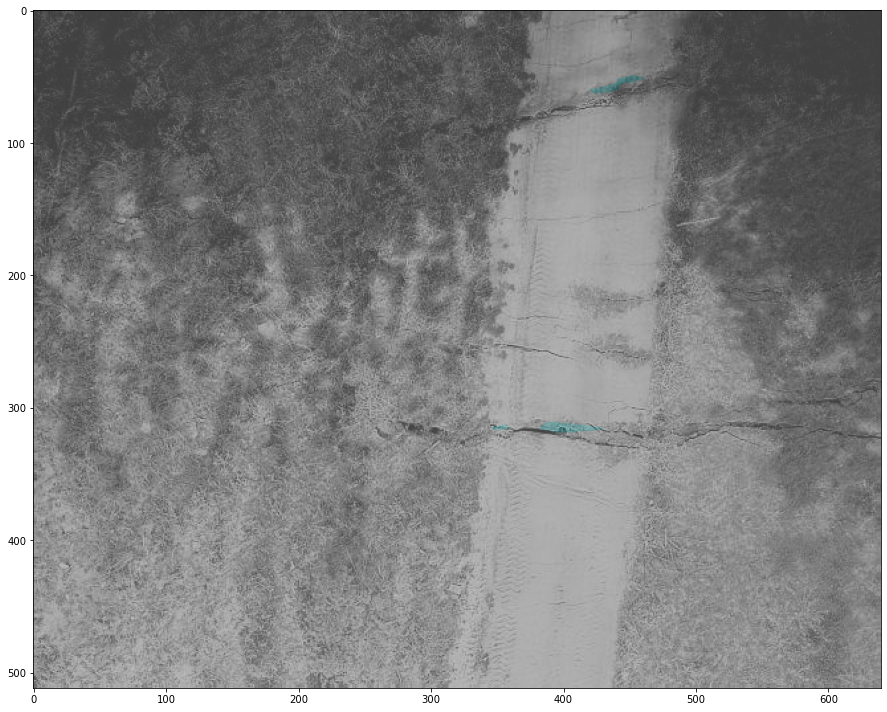

In [6]:
# show the results
show_result_pyplot(model, img, result)